In [65]:
import os
import sys
import torch
import numpy as np
from glob import glob
import torch.nn.functional as F

import torch.nn as nn

from torch.utils.data import Dataset
from torch.optim.lr_scheduler import MultiStepLR
from matplotlib import pyplot as plt
%matplotlib inline

In [137]:
batch_size = 32
num_workers = 1
train_val_ratio = 0.9

class FacialDataset(Dataset):
    def __init__(self, data_path):
        if not os.path.exists(data_path):
            raise Exception(f"[!] {self.data_path} not existed")
        self.imgs = []
        self.labels = []
        self.length = 0
        self.action_path = sorted(glob(os.path.join(data_path, "*.*")))
        for i, pth in enumerate(self.action_path):
          with open(pth, 'r') as f:
            for line in f.readlines():
              self.imgs.extend([list(map(float, line.split(',')))])
              self.labels.append(i)
              self.length += 1
        self.imgs = torch.from_numpy(np.array(self.imgs)).float()
        self.labels = torch.from_numpy(np.array(self.labels)).float()

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.labels[idx]
        return image, label

    def __len__(self):
        return self.length

def get_data_loader(data_path, batch_size, num_workers,train_val_ratio):
    full_dataset = FacialDataset(data_path)
    train_size = int(train_val_ratio * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    torch.manual_seed(3334)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers, pin_memory=False)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader

train_loader, val_loader = get_data_loader('/content/dataset',batch_size,num_workers,train_val_ratio)

In [138]:
num_classes = 4

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        h1 = nn.Linear(99, 50)
        h2 = nn.Linear(50, 35)
        h3 = nn.Linear(35, 1)
        self.hidden = nn.Sequential(
            h1,
            nn.Tanh(),
            h2,
            nn.Tanh(),
            h3,
        )
        if torch.cuda.is_available():
            self.hidden = self.hidden.cuda()
        
    def forward(self, x):
        out = self.hidden(x)
        return out.view(-1)

In [141]:
learning_rate = 5e-5

model = DNN().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = MultiStepLR(optimizer, milestones=[15, 30], gamma=0.2)

In [142]:
num_epochs = 45
criterion = nn.MSELoss().cuda()

trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    losses = 0.0
    for i, train in enumerate(train_loader):
        train_X, train_y = train
        if torch.cuda.is_available():
            train_X, train_y = train_X.cuda(), train_y.cuda()
        optimizer.zero_grad()
        pred = model(train_X)
        loss = criterion(pred, train_y)
        loss.backward()
        optimizer.step()
        
        losses += loss
        
        if (i+1) % 15 == 0:
            with torch.no_grad():
                val_loss_summary = 0.0
                for j, val in enumerate(val_loader):
                    val_X, val_y = val
                    if torch.cuda.is_available():
                        val_X, val_y = val_X.cuda(), val_y.cuda()
                    val_pred = model(val_X)
                    val_loss = criterion(val_pred, val_y)
                    val_loss_summary += val_loss
                
            print("epoch: {}/{} | step: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch + 1, num_epochs, i+1, len(train_loader), (loss/15)**(1/2), (val_loss_summary/len(val_loader))**(1/2)
            ))
                
            trn_loss_list.append((loss/15)**(1/2))
            val_loss_list.append((val_loss_summary/len(val_loader))**(1/2))
            trn_loss_summary = 0.0
        
print("finish Training")

epoch: 1/45 | step: 15/19 | trn_loss: 0.5072 | val_loss: 1.9338
epoch: 2/45 | step: 15/19 | trn_loss: 0.5190 | val_loss: 1.8773
epoch: 3/45 | step: 15/19 | trn_loss: 0.5210 | val_loss: 1.8204
epoch: 4/45 | step: 15/19 | trn_loss: 0.5144 | val_loss: 1.7617
epoch: 5/45 | step: 15/19 | trn_loss: 0.4764 | val_loss: 1.6997
epoch: 6/45 | step: 15/19 | trn_loss: 0.4891 | val_loss: 1.6320
epoch: 7/45 | step: 15/19 | trn_loss: 0.4683 | val_loss: 1.5628
epoch: 8/45 | step: 15/19 | trn_loss: 0.4493 | val_loss: 1.4888
epoch: 9/45 | step: 15/19 | trn_loss: 0.4623 | val_loss: 1.4119
epoch: 10/45 | step: 15/19 | trn_loss: 0.3860 | val_loss: 1.3334
epoch: 11/45 | step: 15/19 | trn_loss: 0.3399 | val_loss: 1.2552
epoch: 12/45 | step: 15/19 | trn_loss: 0.3937 | val_loss: 1.1781
epoch: 13/45 | step: 15/19 | trn_loss: 0.2598 | val_loss: 1.1063
epoch: 14/45 | step: 15/19 | trn_loss: 0.3109 | val_loss: 1.0406
epoch: 15/45 | step: 15/19 | trn_loss: 0.2788 | val_loss: 0.9824
epoch: 16/45 | step: 15/19 | trn_l

Text(0, 0.5, 'loss')

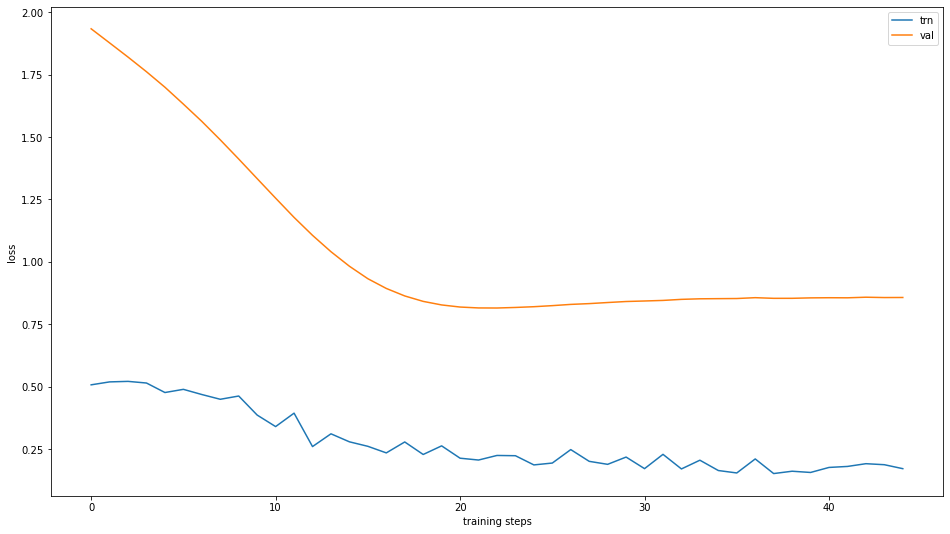

In [143]:
plt.figure(figsize=(16,9))
x_range = range(len(trn_loss_list))
plt.plot(x_range, trn_loss_list, label="trn")
plt.plot(x_range, val_loss_list, label="val")
plt.legend()
plt.xlabel("training steps")
plt.ylabel("loss")

In [148]:
torch.save(model.state_dict(), './model')

In [151]:
model2 = DNN()
model2.load_state_dict(torch.load('./model'))
model2.eval()

tensor([ 2.2255,  2.5099,  2.1097,  2.2349,  2.1479,  2.5812,  2.2160,  2.4282,
         2.2928,  2.1645,  2.1369,  2.1442,  2.5246,  2.0583, -0.1075,  2.4256,
         1.6156,  2.3366,  2.0284,  2.2629,  1.5956,  2.3728], device='cuda:0',
       grad_fn=<ViewBackward>)